# Optimization of PTO Drive-Train with Unstructured Controller

In [7]:
import os
import logging

from autograd.builtins import isinstance, tuple, list, dict
import matplotlib.pyplot as plt
import capytaine as cpy
import autograd.numpy as np
import xarray as xr
from scipy.optimize import brute

from palettable.colorbrewer.sequential import Blues_3 as mc
from palettable.colorbrewer.sequential import OrRd_3 as mc2

import wecopttool as wot


# logging
logging.basicConfig(level=logging.ERROR)

# create save directory
results_dir = 'results_IEEE_2022_unstructured'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)

# frequencies
f0 = 0.05
nfreq = 50

## WEC

In [8]:
# mesh
wb = wot.geom.WaveBot()
mesh_size_factor = 0.5
mesh = wb.mesh(mesh_size_factor)

# floating body
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="HEAVE")

# hydrostatics
hs_data = wot.hydrostatics.hydrostatics(fb)
mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
mass = np.atleast_2d(mass_33)
stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
stiffness = np.atleast_2d(stiffness_33)

# WEC object
wec = wot.WEC(fb, mass, stiffness, f0, nfreq)

# BEM
fname = os.path.join(results_dir, 'bem.nc')
run_bem = True
if os.path.exists(fname):
    try:
        wec.read_bem(fname)
        run_bem = False
    except:
        run_bem = True
if run_bem:
    wec.run_bem()
    wec.write_bem(fname)

## PTO (setup)

In [9]:
# PTO kinematics
kinematics = np.eye(fb.nb_dofs)

# PTO impedance - frequency dependent
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*wec.omega*drivetrain_inertia +
                        drivetrain_friction +
                        -1/(1j*wec.omega)*drivetrain_stiffness)

winding_impedance = winding_resistance + 1j*wec.omega*winding_inductance

pto_impedance_11 = gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = (off_diag+0j) * np.ones(wec.omega.shape)
pto_impedance_21 = pto_impedance_12
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])

# create PTO
ptos = []
ptos.append(wot.pto.PseudoSpectralLinearPTO(nfreq, kinematics, pto_impedance))
ptos.append(wot.pto.PILinearPTO(nfreq, kinematics, pto_impedance))


## Waves

In [10]:
# waves
fp = 1.0/2.0  # Hz
hs = 0.2  # m
gamma = 3.3
# waves = wot.waves.regular_wave(f0=wec.f0,
#                                nfreq=wec.nfreq,
#                                freq=fp,
#                                amplitude=hs/2,)
waves = wot.waves.long_crested_wave(f0=wec.f0, 
                                    nfreq=wec.nfreq, 
                                    spectrum_func=lambda freq: wot.waves.jonswap_spectrum(freq, fp, hs, gamma), 
                                    direction=0.0,
                                    seed=1)
print(f"Repeat period: {1/wec.f0}")

Repeat period: 20.0


## Optimization Run

In [11]:
def outer_opt(x, pto):
    global n, x_wec_0, x_opt_0, scale_x_wec, scale_x_opt, scale_obj
    n += 1
    drivetrain_stiffness = x[0]
    drivetrain_inertia = x[1]

    # update PTO impedance
    drivetrain_impedance = (1j*wec.omega*drivetrain_inertia +
                            drivetrain_friction +
                            -1/(1j*wec.omega)*drivetrain_stiffness)
    pto_impedance_11 = gear_ratio**2 * drivetrain_impedance
    pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                              [pto_impedance_21, pto_impedance_22]])
    # update PTO
    pto.impedance = pto_impedance
    pto._make_abc()
    pto._make_mimo_transfer_mat()

    # update WEC forces
    wec.f_add = pto.force_on_wec

    # update objective function
    obj_fun = pto.electric_average_power
    nstate_opt = pto.nstate

    # solve
    t_sol, f_sol, x_wec, x_opt, avg_power, res = wec.solve(
        waves, obj_fun, nstate_opt, optim_options=options,
        scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj,
        x_wec_0=np.ones(wec.nstate_wec), 
        x_opt_0=np.ones(nstate_opt),
        )
    
    # if avg_power < 0:
    #     scale_x_wec = 1/np.max(np.abs(x_wec))
    #     scale_x_opt = 1/np.max(np.abs(x_opt))
    #     scale_obj = 1/np.max(np.abs(avg_power))

    print(f"{n}/{N}. m: {drivetrain_inertia:.1f}, k:{drivetrain_stiffness:.1f}, " +
          f"exit mode: {res.status}, avg. power: {avg_power:.2f}W")
    
    fig, ax = plt.subplots()
    t_sol.pos.plot(ax=ax)
    fig.savefig(f"{n}.pdf")
    plt.close(fig)
    
    # if avg_power != avg_power: avg_power = 0

    return t_sol, f_sol, x_wec, x_opt, avg_power, res

def out_opt_one_output(x,pto):
    return outer_opt(x, pto)[4]


In [12]:
def list_to_range(l1):
    return slice(l1[0], l1[-1]+np.diff(l1)[0], np.diff(l1)[0])

drivetrain_inertia_list = np.linspace(0.0, 3, 3)  # default: 2.0 
drivetrain_stiffness_list = np.linspace(-7.5e1, 5e1, 3)  # default: 0.0
drivetrain_friction = np.array([1.0])  # default: 1.0

options = {'maxiter': 1e3, 
           'ftol': 1e-8, 
           'disp': True}

N = len(drivetrain_inertia_list) * len(drivetrain_stiffness_list)



# range over which to search
ranges = (list_to_range(drivetrain_stiffness_list), 
          list_to_range(drivetrain_inertia_list),)

# solve
res = []
for pto in ptos:
    scale_x_wec = 1e2
    scale_x_opt = 1e-3
    scale_obj = 1e-1
    x_wec_0 = None
    x_opt_0 = None
    n = 0
    print(f"pto: {pto}")
    res.append(brute(func=lambda x: out_opt_one_output(x, pto),
                    ranges=ranges,
                    full_output=True,
                    finish=None))

# TODO: Theoretical limit on inertia? Exit mode 7 when inertia=4.5, 5.0. Or select better scaling?


pto: <wecopttool.pto.PseudoSpectralLinearPTO object at 0x10e7f3550>
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.0371156477510466
            Iterations: 126
            Function evaluations: 161
            Gradient evaluations: 126
1/9. m: 0.0, k:-75.0, exit mode: 0, avg. power: -30.37W
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3077354046346614
            Iterations: 95
            Function evaluations: 97
            Gradient evaluations: 95
2/9. m: 1.5, k:-75.0, exit mode: 0, avg. power: -33.08W
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4580862936120016
            Iterations: 80
            Function evaluations: 82
            Gradient evaluations: 80
3/9. m: 3.0, k:-75.0, exit mode: 0, avg. power: -34.58W
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.8889006612428383
            Iterat

## Plot

### Contours

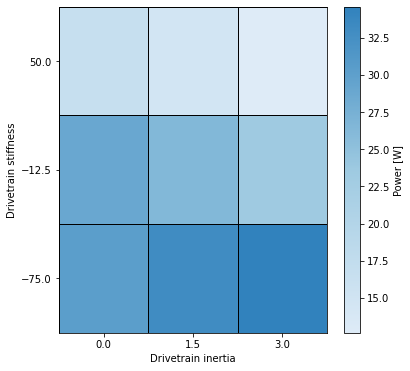

In [13]:
fig, ax = plt.subplots(ncols=1,
                       figsize=(6,6))
pcm = ax.pcolormesh(drivetrain_inertia_list,
                drivetrain_stiffness_list,
                -1*res[0][3],
                # vmin=20,
                cmap=mc.mpl_colormap,
                edgecolor='k',
                )

ax.set_xlabel('Drivetrain inertia')
ax.set_xticks(drivetrain_inertia_list)

ax.set_ylabel('Drivetrain stiffness')
ax.set_yticks(drivetrain_stiffness_list)
pcb = fig.colorbar(pcm, ax=ax)
pcb.set_label('Power [W]')
fig.savefig('IEEE_2022_power_contour_PS.pdf',
            bbox_inches='tight')

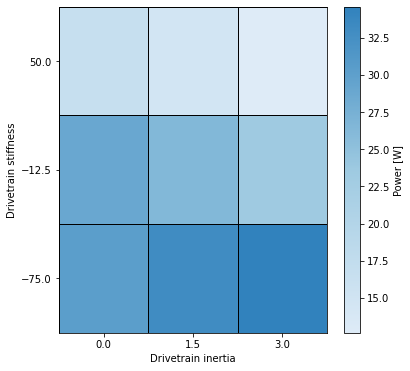

In [14]:
fig, ax = plt.subplots(ncols=1,
                       figsize=(6,6))
pcm = ax.pcolormesh(drivetrain_inertia_list,
                drivetrain_stiffness_list,
                -1*res[0][3],
                # vmin=20,
                cmap=mc.mpl_colormap,
                edgecolor='k',
                )

ax.set_xlabel('Drivetrain inertia')
ax.set_xticks(drivetrain_inertia_list)

ax.set_ylabel('Drivetrain stiffness')
ax.set_yticks(drivetrain_stiffness_list)
pcb = fig.colorbar(pcm, ax=ax)
pcb.set_label('Power [W]')

Average: 0.8879029604511479
Worst case: 0.8486974532411558


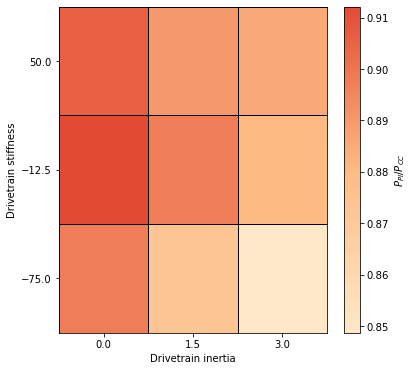

In [15]:
fig, ax = plt.subplots(ncols=1,
                       figsize=(6,6))
pcm = ax.pcolormesh(drivetrain_inertia_list,
                drivetrain_stiffness_list,
                res[1][3]/res[0][3],
                # vmin=20,
                cmap=mc2.mpl_colormap,
                edgecolor='k',
                )

ax.set_xlabel('Drivetrain inertia')
ax.set_xticks(drivetrain_inertia_list)

ax.set_ylabel('Drivetrain stiffness')
ax.set_yticks(drivetrain_stiffness_list)
pcb = fig.colorbar(pcm, ax=ax)
pcb.set_label('$P_{PI} / P_{CC}$')
fig.savefig('IEEE_2022_power_contour_relative.pdf',
            bbox_inches='tight')

print(f"Average: {np.mean(res[1][3]/res[0][3])}")
print(f"Worst case: {np.min(res[1][3]/res[0][3])}")

## Re-run Optimal Case

In [16]:
dss = []
dssf = []
for pto in ptos:
    out = outer_opt(x=res[0][0], 
              pto=pto)
    pto_tdom, pto_fdom = pto.post_process(wec, out[2], out[3])
    dss.append(xr.merge([out[0], pto_tdom.drop(['pos','vel','acc'])]))
    dssf.append(xr.merge([out[1], pto_fdom.drop(['pos','vel','acc'])]))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4580862936120016
            Iterations: 80
            Function evaluations: 82
            Gradient evaluations: 80
10/9. m: 3.0, k:-75.0, exit mode: 0, avg. power: -34.58W
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.934869030476653
            Iterations: 25
            Function evaluations: 29
            Gradient evaluations: 25
11/9. m: 3.0, k:-75.0, exit mode: 0, avg. power: -29.35W


### Synthesize results

In [17]:
ds = xr.concat(dss, dim='pto').assign_coords(dict(pto=['Unstructured','PI'])).squeeze()
ds.pto.attrs['long_name'] = 'PTO'
ds

<xarray.Dataset>
Dimensions:           (time: 101, pto: 2)
Coordinates:
  * time              (time) float64 0.0 0.198 0.396 0.5941 ... 19.41 19.6 19.8
    influenced_dof    <U5 'HEAVE'
    dof_pto           <U5 'pto_1'
  * pto               (pto) <U12 'Unstructured' 'PI'
Data variables:
    pos               (pto, time) float64 0.01507 0.02896 ... -0.0005332
    vel               (pto, time) float64 0.08743 0.05475 ... 0.09716 0.1121
    acc               (pto, time) float64 -0.1854 -0.1341 ... 0.1735 -0.02807
    f_add             (pto, time) float64 5.459 392.5 587.7 ... -321.6 -146.9
    excitation_force  (pto, time) float64 202.3 132.9 65.19 ... 253.9 267.7
    wave_elevation    (pto, time) float64 0.03441 0.03341 ... -0.005789 0.01068
    force             (pto, time) float64 5.459 392.5 587.7 ... -321.6 -146.9
    power             (pto, time) float64 0.4772 21.49 18.23 ... -31.25 -16.46
    current           (pto, time) float64 -0.9113 1.318 2.38 ... -1.766 -1.474
    voltage           (pto, time) float64 7.67 4.716 2.45 ... 5.438 9.435 10.31
    epower            (pto, time) float64 -6.99 6.217 5.831 ... -16.66 -15.19

In [26]:
dsf = xr.concat(dssf, dim='pto').assign_coords(dict(pto=['Unstructured','PI'])).squeeze()
dsf.pto.attrs['long_name'] = 'PTO'
dsf

<xarray.Dataset>
Dimensions:           (omega: 51, pto: 2)
Coordinates:
  * omega             (omega) float64 0.0 0.3142 0.6283 ... 15.08 15.39 15.71
    influenced_dof    <U5 'HEAVE'
    wave_direction    float64 0.0
    dof_pto           <U5 'pto_1'
  * pto               (pto) <U12 'Unstructured' 'PI'
Data variables:
    pos               (pto, omega) complex128 (3.3575940471394353e-18+0j) ......
    vel               (pto, omega) complex128 0j ... (-8.830313435219102e-07-...
    acc               (pto, omega) complex128 0j ... (2.1465402715330517e-05-...
    f_add             (pto, omega) complex128 (3.5569347247555116e-13+0j) ......
    wave_elevation    (pto, omega) complex128 0j ... (-0.0003062066285204622+...
    excitation_force  (pto, omega) complex128 0j ... (0.028305755414541195-0....
    force             (pto, omega) complex128 (3.5569347247555116e-13+0j) ......
    power             (pto, omega) complex128 (-62.03207681007837+0j) ... (-0...
    current           (pto, omega) complex128 (4.836615156782861e-16+0j) ... ...
    voltage           (pto, omega) complex128 (-5.346658209679962e-15+0j) ......
    epower            (pto, omega) complex128 (-69.16172587224+0j) ... (-0.00...

### Plot time series

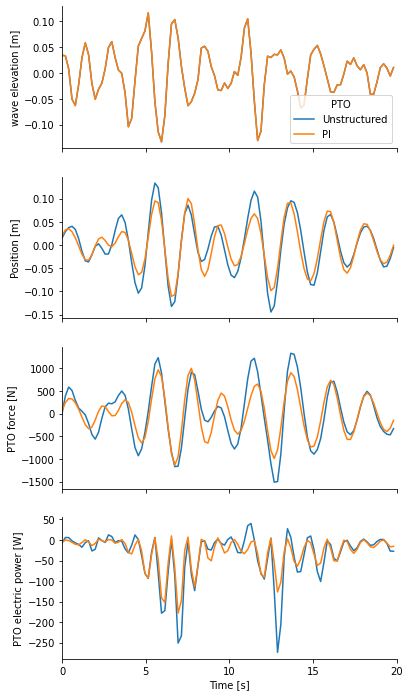

In [19]:
fig, ax = plt.subplots(nrows=4,
                       figsize=(6,12))

ds.wave_elevation.plot(ax=ax[0],
            hue='pto')

ds.pos.plot(ax=ax[1],
            hue='pto',
            add_legend=False,)

ax[1].set_ylabel('Position [m]')

ds.f_add.plot(ax=ax[2],
            hue='pto',
            add_legend=False,)

ax[2].set_ylabel('PTO force [N]')

# ds.power.plot(ax=ax[3],
#             hue='pto',
#             linestyle='--',
#             add_legend=False,
#             )

ax[3].set_prop_cycle(None)

ds.epower.plot(ax=ax[3],
            hue='pto',
            linestyle='-',
            add_legend=False,
            )


# ax[3].set_ylabel('Power [W]')


for axi in ax:
    axi.label_outer()
    axi.set_title('')
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.autoscale(axis='x',tight=True)
    axi.set_xticks(np.arange(0,20+1,5))
    
    
fig.savefig('IEEE_2022_timeseries.pdf',
            bbox_inches='tight')

### Plot spectra

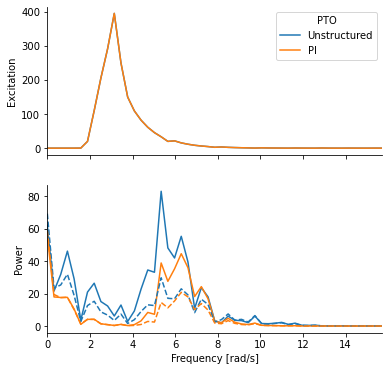

In [27]:
fig, ax = plt.subplots(figsize=(6,6),
                       nrows=2)


np.abs(dsf.excitation_force).plot(ax=ax[0],
                        hue='pto')

ax[0].set_ylabel('Excitation')

np.abs(dsf.power).plot(ax=ax[1],
                       hue='pto',
                       add_legend=False)
ax[1].set_prop_cycle(None)

np.abs(dsf.epower).plot(ax=ax[1],
                        hue='pto',
                        linestyle='--',
                        add_legend=False)

ax[1].set_ylabel('Power')

for axi in ax:
    axi.set_title('')
    axi.label_outer()
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.autoscale(axis='x',tight=True)

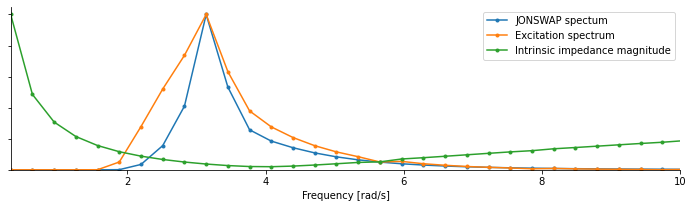

In [30]:
fig, ax = plt.subplots(figsize=(12,3))
(waves.S/waves.S.max()).squeeze().plot(ax=ax,
                                       marker='.')
(np.abs(dsf.excitation_force)/np.abs(dsf.excitation_force).max()).isel(pto=0).plot(ax=ax,
                                                                                   marker='.')
(np.abs(wec.hydro['Zi'])/np.abs(wec.hydro['Zi']).max()).squeeze().plot(ax=ax,
                                       marker='.')
ax.set_ylabel('')
ax.set_xlabel('Frequency [rad/s]')
ax.set_yticklabels('')
ax.set_ylim(bottom=0)
ax.set_title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(left=wec.f0*2*np.pi, right=10)
ax.legend(['JONSWAP spectum',
           'Excitation spectrum',
           'Intrinsic impedance magnitude'],
          loc=1)

fig.savefig('IEEE_2022_input_spectra.pdf',
            bbox_inches='tight')